In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from pathlib import Path

from keras import models
from keras.models import load_model
from keras.utils import load_img, img_to_array

In [2]:
base_model = load_model(filepath="base_modelv03.h5")
base_model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)     

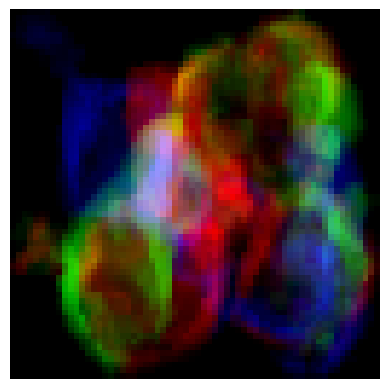

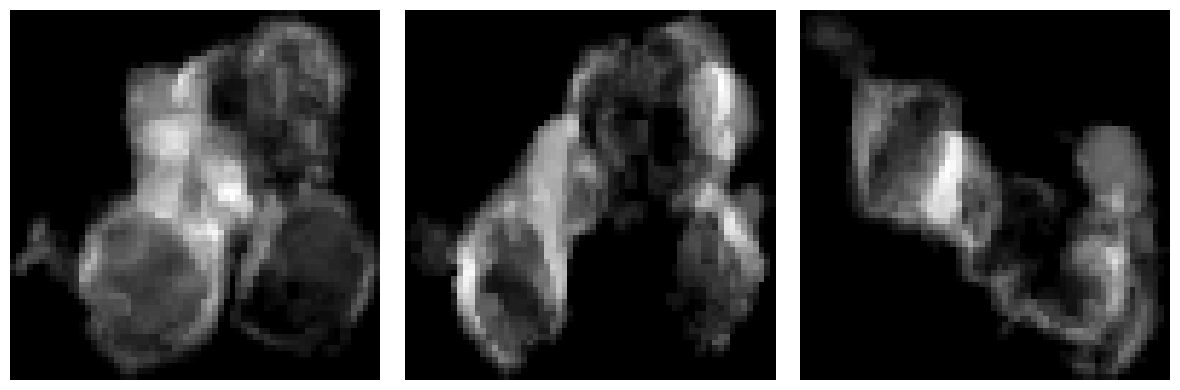

In [3]:
img_path = Path("example_grains", "multi03_CTS242_arr2229.png")
img = load_img(img_path, target_size=(64, 64))
img_tensor = img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

fig, ax = plt.subplots()
ax.imshow(img_tensor[0])
ax.axis("off")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    axs[i].imshow(img_tensor[0][:,:,i], cmap="gray")
    axs[i].axis("off")
fig.tight_layout()

Class indices:
- 0: Atoll
- 1: Pitted
- 2: Intact
- 3: Multi
- 4: Edge

In [4]:
pred = base_model.predict(img_tensor)
print("Predicted class idx:", tf.argmax(pred[0]).numpy())

1/1 [==============================] - 0s 195ms/step
Predicted class idx: 3


## Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
arXiv:1610.02391

In [5]:
last_convolutional_layer = base_model.get_layer("conv2d_3")

feature_extraction_model = models.Model(base_model.inputs, last_convolutional_layer.output)

feature_extraction_output = feature_extraction_model(img_tensor)
predictions = base_model(img_tensor)

# Get channel of predicted class
top_predictions_index = tf.argmax(predictions[0])
top_class_channel = predictions[:, top_predictions_index]

later_layers = [layer.name for layer in base_model.layers][[layer.name for layer in base_model.layers].index("conv2d_3")+1:]

classifier_input = keras.layers.Input(shape=last_convolutional_layer.output.shape[1:])
x = classifier_input
for layer_name in later_layers:
    x = base_model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

with tf.GradientTape() as tape:
    feature_extraction_output = feature_extraction_model(img_tensor)
    tape.watch(feature_extraction_output)
    predictions = classifier_model(feature_extraction_output)
    top_predictions_index = tf.argmax(predictions[0])
    top_class_channel = predictions[:, top_predictions_index]

gradients = tape.gradient(top_class_channel, feature_extraction_output)

pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2)).numpy()
feature_extraction_output = feature_extraction_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    feature_extraction_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(feature_extraction_output, axis=-1)

(-0.5, 7.5, 7.5, -0.5)

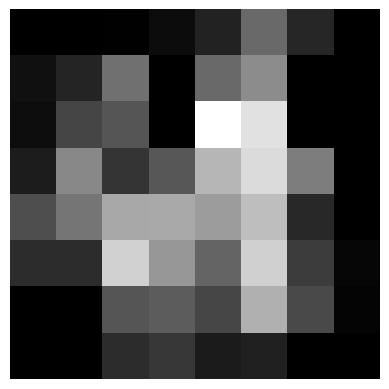

In [6]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

fig, ax = plt.subplots()
ax.imshow(heatmap, cmap="gray")
ax.axis("off")

In [20]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

# expand the last dimension of heatmap to match the shape of an img
heatmap_expaned = np.expand_dims(heatmap, axis=-1)

heatmap_rescaled = keras.utils.array_to_img(heatmap_expaned)
heatmap_rescaled = heatmap_rescaled.resize((img.shape[1], img.shape[0]))
heatmap_rescaled = keras.utils.img_to_array(heatmap_rescaled)

superimposed_img = heatmap_rescaled * 1.5 + img
# superimposed_img = heatmap_rescaled * img

superimposed_img = keras.utils.array_to_img(superimposed_img, scale=True)

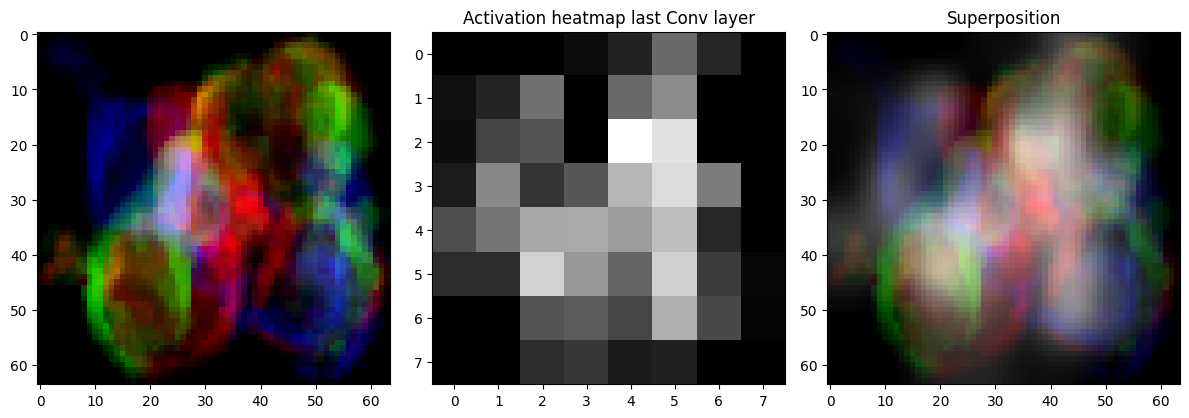

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_tensor[0])
axs[1].set_title("Activation heatmap last Conv layer")
axs[1].imshow(heatmap, cmap="gist_gray")
axs[2].set_title("Superposition")
axs[2].imshow(superimposed_img)
fig.tight_layout()